# Código testando as estratégias de divisão dos dados sem fine-tuning

100 épocas.
Usando Shuffle = True em tudo e sem semente

Neste código serão criados 3 modelos usando 3 estratégias diferentes. Os modelos serão treinados, validados e testados usando  o dataset Supermarket Produce (ROCHA et al., 2010).

As estratégias serão as seguintes:
- 1ª estratégia (2_est): 50% do dataset para treino e 50% para teste;
- 2ª estratégia (3_est): 70% do dataset para treino e 30% para teste;
- 3ª estratégia (4_est): 80% do dataset para treino e 20% para teste.

In [1]:
import tensorflow as tf
print("Versão do TensorFlow:", tf.__version__)

from tensorflow import keras
print("versão do Keras:", keras.__version__)

# IMPORTANDO COMANDOS E FUNÇÕES #

import numpy             as np
import h5py
import matplotlib.pyplot as plt #gerar gráfico
import os
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks           import EarlyStopping

from sklearn.metrics import classification_report, confusion_matrix, balanced_accuracy_score, accuracy_score

import pickle

# IMPORTANDO LAYERS PARA A CNN #

from keras.models import Sequential
from keras        import layers
from keras.layers import Dropout

Versão do TensorFlow: 2.5.0
versão do Keras: 2.5.0


In [2]:
print("versao do h5py:", h5py.__version__)

versao do h5py: 3.1.0


In [3]:
# MONTANDO A ESTRUTURA DA CNN #

modelo = Sequential()
modelo.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(100, 100, 3)))
modelo.add(layers.MaxPooling2D((2, 2)))
modelo.add(Dropout(0.5)) # dropout de 50%
modelo.add(layers.Conv2D(64, (3, 3), activation='relu'))
modelo.add(layers.MaxPooling2D((2, 2)))
modelo.add(Dropout(0.5))
modelo.add(layers.Conv2D(64, (3, 3), activation='relu'))
modelo.add(layers.MaxPooling2D((2, 2)))
modelo.add(Dropout(0.5))

modelo.add(layers.Flatten()) # camada de achatamento
modelo.add(layers.Dense(64, activation='relu'))
modelo.add(Dropout(0.5))
modelo.add(layers.Dense(units = 11, activation = 'softmax')) # 11 unidades de saída (11 classes)

In [4]:
modelo.summary() # resumo da estrutura, com os parâmetros ajustáveis

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 98, 98, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 49, 49, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 47, 47, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 21, 21, 64)        3

In [5]:
modelo.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(
                  from_logits=False,
                  label_smoothing=0,                            #configurações da função loss
                  reduction="auto",
                  name="categorical_crossentropy"),
              metrics=['accuracy'])

In [6]:
modelo.save('model_base.h5',
          overwrite = True) 

In [7]:
# Importando a função (criada pelo Gustavo) que faz a separação dos dados em treino e teste

from functions_extras_v2 import criar_treino_teste

Criando particionamento
	 492 	+ 164 	= 656 	 -> apple1
	 492 	+ 164 	= 656 	 -> granny_smith_apple
	 466 	+ 156 	= 622 	 -> kiwi
	 492 	+ 164 	= 656 	 -> lime
	 492 	+ 164 	= 656 	 -> nectarine
	 438 	+ 146 	= 584 	 -> onion
	 492 	+ 164 	= 656 	 -> peach
	 492 	+ 164 	= 656 	 -> pear
	 421 	+ 141 	= 562 	 -> plum
	 450 	+ 150 	= 600 	 -> potato
	 474 	+ 158 	= 632 	 -> watermelon
Particionamento criado com sucesso!


## Primeira estratégia: 50% treino 50% teste

In [8]:
# Puxando a estrutura base da rede

model_n1 = keras.models.load_model('model_base.h5')

In [9]:
model_n1.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(
                  from_logits=False,
                  label_smoothing=0,                            #configurações da função loss
                  reduction="auto",
                  name="categorical_crossentropy"),
              metrics=['accuracy'])

In [10]:
criar_treino_teste('./dataset_smkt/', 0.5)

Criando particionamento
	 106 	+ 106 	= 212 	 -> apple1
	 77 	+ 78 	= 155 	 -> granny_smith_apple
	 85 	+ 86 	= 171 	 -> kiwi
	 53 	+ 53 	= 106 	 -> lime
	 123 	+ 124 	= 247 	 -> nectarine
	 37 	+ 38 	= 75 	 -> onion
	 105 	+ 106 	= 211 	 -> peach
	 79 	+ 80 	= 159 	 -> pear
	 132 	+ 132 	= 264 	 -> plum
	 100 	+ 101 	= 201 	 -> potato
	 96 	+ 96 	= 192 	 -> watermelon
Particionamento criado com sucesso!


In [11]:
# DIVIDIR AS IMAGENS EM PARTIÇÃO DE TREINO E VALIDAÇÃO, UTILIZANDO O IMAGEDATAGENERATOR #

datagen =  ImageDataGenerator(rescale = 1./255, validation_split=0.25) # comando para reescala + divisão em 20% para validação

# imagens de treino (75%) 

train_data = datagen.flow_from_directory('dataset_smkt/train', 
                                         subset = 'training',
                                         batch_size = 64,
                                         shuffle = True,
                                         target_size = (100, 100)) # definindo tamanho das imagens

# imagens de validação (25%)

valid_data = datagen.flow_from_directory('dataset_smkt/train',
                                         subset = 'validation',
                                         batch_size = 64,
                                         shuffle = True,
                                         target_size = (100, 100))

Found 748 images belonging to 11 classes.
Found 245 images belonging to 11 classes.


In [12]:
# INÍCIO DO TREINO DO MODELO #

history = model_n1.fit(train_data,
                    epochs=100,
                    validation_data=valid_data,
                    verbose=True)

# informação: steps_per_epoch = número de imagens / batch_size

Epoch 1/100
12/12 [==============================] - 15s 1s/step - loss: 2.5216 - accuracy: 0.1230 - val_loss: 2.3946 - val_accuracy: 0.1347
Epoch 2/100
12/12 [==============================] - 15s 1s/step - loss: 2.3719 - accuracy: 0.1243 - val_loss: 2.3884 - val_accuracy: 0.1347
Epoch 3/100
12/12 [==============================] - 15s 1s/step - loss: 2.3490 - accuracy: 0.1243 - val_loss: 2.3818 - val_accuracy: 0.1551
Epoch 4/100
12/12 [==============================] - 15s 1s/step - loss: 2.3232 - accuracy: 0.1324 - val_loss: 2.3789 - val_accuracy: 0.2653
Epoch 5/100
12/12 [==============================] - 16s 1s/step - loss: 2.2516 - accuracy: 0.1872 - val_loss: 2.2971 - val_accuracy: 0.2408
Epoch 6/100
12/12 [==============================] - 17s 1s/step - loss: 2.1755 - accuracy: 0.2005 - val_loss: 2.2557 - val_accuracy: 0.3102
Epoch 7/100
12/12 [==============================] - 16s 1s/step - loss: 2.0991 - accuracy: 0.2500 - val_loss: 2.1554 - val_accuracy: 0.2531
Epoch 8/100
1

Epoch 59/100
12/12 [==============================] - 15s 1s/step - loss: 0.5206 - accuracy: 0.7741 - val_loss: 1.4416 - val_accuracy: 0.5714
Epoch 60/100
12/12 [==============================] - 16s 1s/step - loss: 0.5381 - accuracy: 0.7607 - val_loss: 1.1820 - val_accuracy: 0.6041
Epoch 61/100
12/12 [==============================] - 15s 1s/step - loss: 0.4932 - accuracy: 0.8008 - val_loss: 1.1360 - val_accuracy: 0.6449
Epoch 62/100
12/12 [==============================] - 15s 1s/step - loss: 0.6042 - accuracy: 0.7473 - val_loss: 1.0853 - val_accuracy: 0.6327
Epoch 63/100
12/12 [==============================] - 15s 1s/step - loss: 0.4621 - accuracy: 0.8021 - val_loss: 1.4533 - val_accuracy: 0.5878
Epoch 64/100
12/12 [==============================] - 16s 1s/step - loss: 0.5260 - accuracy: 0.7660 - val_loss: 1.3287 - val_accuracy: 0.5714
Epoch 65/100
12/12 [==============================] - 15s 1s/step - loss: 0.4490 - accuracy: 0.8182 - val_loss: 1.2657 - val_accuracy: 0.6327
Epoch 

In [13]:
model_n1.save('model_n1.h5',
          overwrite = True) 
del model_n1

with open('trainHistoryDict_model_n1', 'wb') as file_pi:
        pickle.dump(history.history, file_pi)

In [14]:
model_n1 = keras.models.load_model('model_n1.h5')
history = pickle.load(open('trainHistoryDict_model_n1', "rb"))

In [15]:
model_n1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 98, 98, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 49, 49, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 47, 47, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 21, 21, 64)        3

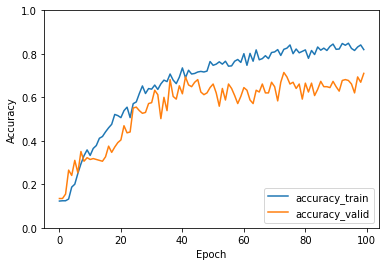

In [16]:
# GERANDO GRÁFICO COM RESULTADOS DAS ACURÁCIAS DE TREINO E VALIDAÇÃO #

plt.plot(history['accuracy'], label='accuracy_train')
plt.plot(history['val_accuracy'], label = 'accuracy_valid')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

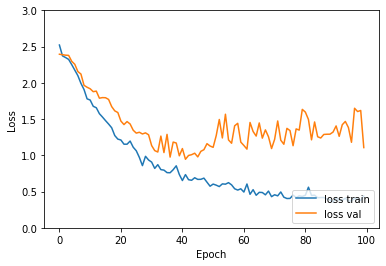

In [17]:
# GERANDO GRÁFICO COM RESULTADOS DO LOSS DE TREINO E VALIDAÇÃO #

plt.plot(history['loss'], label='loss train')
plt.plot(history['val_loss'], label='loss val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 3])
plt.legend(loc='lower right')

In [18]:
datagen_test =  ImageDataGenerator(rescale = 1./255) # comando para reescala das imagens de teste

# imagens de teste

test_data = datagen_test.flow_from_directory(directory='dataset_smkt/test',
                                                      target_size = (100, 100),
                                                      batch_size = 64,
                                                      shuffle=False)

Found 1000 images belonging to 11 classes.


In [19]:
# DEFININDO COMANDO PARA AVALIAR O DESEMPENHO DO MODELO NAS IMAGENS DE TESTE #

test_loss, test_acc = model_n1.evaluate(test_data) # verificar versão do Keras

print("acurácia nos dados de teste:", test_acc)
print("loss dos dados de teste:", test_loss)

16/16 [==============================] - 11s 655ms/step - loss: 0.4363 - accuracy: 0.8680
acurácia nos dados de teste: 0.8679999709129333
loss dos dados de teste: 0.43632906675338745


In [20]:
Y_pred = model_n1.predict(test_data)
y_pred = np.argmax(Y_pred, axis=1)

print(y_pred.shape)

print('Accuracy')
print(accuracy_score(test_data.classes,y_pred))

print('Balanced Accuracy')
print(balanced_accuracy_score(test_data.classes,y_pred))

print('Confusion Matrix')
print(confusion_matrix(test_data.classes, y_pred))
print('Classification Report')

(1000,)
Accuracy
0.868
Balanced Accuracy
0.8602128164904258
Confusion Matrix
[[ 89   0   4   0   4   0   8   0   1   0   0]
 [  0  66   1   0   0   0   0   0   0   0  11]
 [  0   0  53   0  30   0   2   0   0   1   0]
 [  0   0   0  53   0   0   0   0   0   0   0]
 [  2   0   0   0 121   0   1   0   0   0   0]
 [  0   0   0   0   0  31   0   0   0   7   0]
 [ 13   0   0   0   0   0  93   0   0   0   0]
 [  0   0   6   0   2   0   4  67   1   0   0]
 [  0   0   1   0   0   0   0   0 131   0   0]
 [  0   0   2   0   0   0   0   8   0  91   0]
 [  0  19   0   0   0   0   0   4   0   0  73]]
Classification Report


## Segunda estratégia: 70% treino e 30% teste

In [21]:
# Puxando estrutura do modelo base

model_n2 = keras.models.load_model('model_base.h5')

In [22]:
model_n2.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(
                  from_logits=False,
                  label_smoothing=0,                            #configurações da função loss
                  reduction="auto",
                  name="categorical_crossentropy"),
              metrics=['accuracy'])

In [23]:
criar_treino_teste('./dataset_smkt/', 0.3)

Criando particionamento
	 148 	+ 64 	= 212 	 -> apple1
	 108 	+ 47 	= 155 	 -> granny_smith_apple
	 119 	+ 52 	= 171 	 -> kiwi
	 74 	+ 32 	= 106 	 -> lime
	 172 	+ 75 	= 247 	 -> nectarine
	 52 	+ 23 	= 75 	 -> onion
	 147 	+ 64 	= 211 	 -> peach
	 111 	+ 48 	= 159 	 -> pear
	 184 	+ 80 	= 264 	 -> plum
	 140 	+ 61 	= 201 	 -> potato
	 134 	+ 58 	= 192 	 -> watermelon
Particionamento criado com sucesso!


In [24]:
# DIVIDIR AS IMAGENS EM PARTIÇÃO DE TREINO E VALIDAÇÃO, UTILIZANDO O IMAGEDATAGENERATOR #

datagen =  ImageDataGenerator(rescale = 1./255, validation_split=0.25) # comando para reescala + divisão em 20% para validação

# imagens de treino (75%) 

train_data = datagen.flow_from_directory('dataset_smkt/train', 
                                         subset = 'training',
                                         batch_size = 64,
                                         shuffle = True,
                                         target_size = (100, 100)) # definindo tamanho das imagens

# imagens de validação (25%)

valid_data = datagen.flow_from_directory('dataset_smkt/train',
                                         subset='validation',
                                         batch_size = 64,
                                         shuffle = True,
                                         target_size = (100, 100))

Found 1045 images belonging to 11 classes.
Found 344 images belonging to 11 classes.


In [25]:
# INÍCIO DO TREINO DO MODELO #

history = model_n2.fit(train_data,
                    epochs=100,
                    validation_data=valid_data)

# informação: steps_per_epoch = número de imagens / batch_size

Epoch 1/100
17/17 [==============================] - 24s 1s/step - loss: 2.5166 - accuracy: 0.1234 - val_loss: 2.3937 - val_accuracy: 0.1337
Epoch 2/100
17/17 [==============================] - 21s 1s/step - loss: 2.3678 - accuracy: 0.1072 - val_loss: 2.3876 - val_accuracy: 0.1395
Epoch 3/100
17/17 [==============================] - 21s 1s/step - loss: 2.3283 - accuracy: 0.1416 - val_loss: 2.3626 - val_accuracy: 0.1977
Epoch 4/100
17/17 [==============================] - 22s 1s/step - loss: 2.2307 - accuracy: 0.1761 - val_loss: 2.2330 - val_accuracy: 0.2006
Epoch 5/100
17/17 [==============================] - 21s 1s/step - loss: 2.1006 - accuracy: 0.2211 - val_loss: 2.1773 - val_accuracy: 0.3198
Epoch 6/100
17/17 [==============================] - 21s 1s/step - loss: 2.0148 - accuracy: 0.2938 - val_loss: 2.0943 - val_accuracy: 0.3052
Epoch 7/100
17/17 [==============================] - 22s 1s/step - loss: 1.9049 - accuracy: 0.3464 - val_loss: 1.9962 - val_accuracy: 0.3023
Epoch 8/100
1

Epoch 59/100
17/17 [==============================] - 21s 1s/step - loss: 0.3543 - accuracy: 0.8526 - val_loss: 0.6150 - val_accuracy: 0.7762
Epoch 60/100
17/17 [==============================] - 22s 1s/step - loss: 0.3462 - accuracy: 0.8574 - val_loss: 0.6483 - val_accuracy: 0.7907
Epoch 61/100
17/17 [==============================] - 21s 1s/step - loss: 0.3979 - accuracy: 0.8373 - val_loss: 0.5912 - val_accuracy: 0.8081
Epoch 62/100
17/17 [==============================] - 21s 1s/step - loss: 0.4120 - accuracy: 0.8431 - val_loss: 0.6862 - val_accuracy: 0.7791
Epoch 63/100
17/17 [==============================] - 22s 1s/step - loss: 0.3430 - accuracy: 0.8670 - val_loss: 0.7813 - val_accuracy: 0.7587
Epoch 64/100
17/17 [==============================] - 21s 1s/step - loss: 0.3811 - accuracy: 0.8383 - val_loss: 1.1185 - val_accuracy: 0.7384
Epoch 65/100
17/17 [==============================] - 22s 1s/step - loss: 0.4040 - accuracy: 0.8411 - val_loss: 0.8799 - val_accuracy: 0.7006
Epoch 

In [26]:
model_n2.save('model_n2.h5',
          overwrite = True) 
del model_n2

with open('trainHistoryDict_model_n2', 'wb') as file_pi:
        pickle.dump(history.history, file_pi)

In [27]:
model_n2 = keras.models.load_model('model_n2.h5')
history = pickle.load(open('trainHistoryDict_model_n2', "rb"))

In [28]:
model_n2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 98, 98, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 49, 49, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 47, 47, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 21, 21, 64)        3

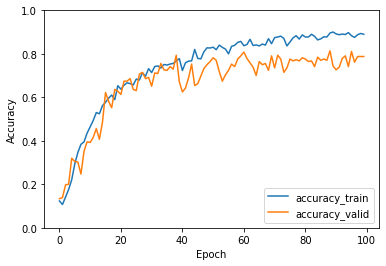

In [29]:
# GERANDO GRÁFICO COM RESULTADOS DAS ACURÁCIAS DE TREINO E VALIDAÇÃO #

plt.plot(history['accuracy'], label='accuracy_train')
plt.plot(history['val_accuracy'], label = 'accuracy_valid')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

Trocar dados de teste e validação durante treino.

Esperado que a curva de acc_valid com essa troca esteja mais próxima da curva de acc_train.

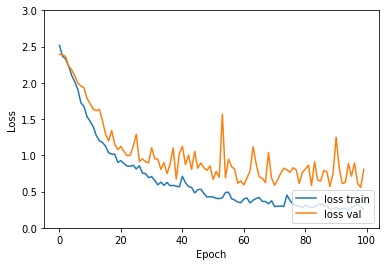

In [30]:
# GERANDO GRÁFICO COM RESULTADOS DO LOSS DE TREINO E VALIDAÇÃO #

plt.plot(history['loss'], label='loss train')
plt.plot(history['val_loss'], label='loss val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 3])
plt.legend(loc='lower right')

In [31]:
datagen_test =  ImageDataGenerator(rescale = 1./255) # comando para reescala das imagens de teste

# imagens de teste

test_data          = datagen_test.flow_from_directory(directory='dataset_smkt/test',
                                                      target_size = (100, 100),
                                                      batch_size = 64,
                                                      shuffle=False)

Found 604 images belonging to 11 classes.


In [32]:
# DEFININDO COMANDO PARA AVALIAR O DESEMPENHO DO MODELO NAS IMAGENS DE TESTE #

test_loss, test_acc = model_n2.evaluate(test_data) # verificar versão do Keras

print("acurácia nos dados de teste:", test_acc)
print("loss dos dados de teste:", test_loss)

10/10 [==============================] - 7s 642ms/step - loss: 0.4143 - accuracy: 0.8907
acurácia nos dados de teste: 0.8907284736633301
loss dos dados de teste: 0.41432124376296997


In [33]:
Y_pred = model_n2.predict(test_data)
y_pred = np.argmax(Y_pred, axis=1)

print(y_pred.shape)

print('Accuracy')
print(accuracy_score(test_data.classes,y_pred))

print('Balanced Accuracy')
print(balanced_accuracy_score(test_data.classes,y_pred))

print('Confusion Matrix')
print(confusion_matrix(test_data.classes, y_pred))
print('Classification Report')

(604,)
Accuracy
0.890728476821192
Balanced Accuracy
0.8970339923518182
Confusion Matrix
[[54  0  0  0  0  0  6  3  1  0  0]
 [ 0 37  0  0  0  0  0  0  0  0 10]
 [ 0  0 51  0  1  0  0  0  0  0  0]
 [ 0  0  0 32  0  0  0  0  0  0  0]
 [ 8  0  1  0 66  0  0  0  0  0  0]
 [ 0  0  0  0  0 23  0  0  0  0  0]
 [10  0  0  0  0  0 54  0  0  0  0]
 [ 3  0  0  0  0  0  8 37  0  0  0]
 [ 2  0  0  0  0  0  0  0 78  0  0]
 [ 0  0 11  0  0  0  0  1  0 49  0]
 [ 0  0  0  0  0  0  0  1  0  0 57]]
Classification Report


## Terceira estratégia: 80% treino e 20% teste

In [34]:
# Criando modelo

model_n3 = keras.models.load_model('model_base.h5')

In [35]:
model_n3.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(
                  from_logits=False,
                  label_smoothing=0,                            #configurações da função loss
                  reduction="auto",
                  name="categorical_crossentropy"),
              metrics=['accuracy'])

In [36]:
criar_treino_teste('./dataset_smkt/', 0.2)

Criando particionamento
	 169 	+ 43 	= 212 	 -> apple1
	 124 	+ 31 	= 155 	 -> granny_smith_apple
	 136 	+ 35 	= 171 	 -> kiwi
	 84 	+ 22 	= 106 	 -> lime
	 197 	+ 50 	= 247 	 -> nectarine
	 60 	+ 15 	= 75 	 -> onion
	 168 	+ 43 	= 211 	 -> peach
	 127 	+ 32 	= 159 	 -> pear
	 211 	+ 53 	= 264 	 -> plum
	 160 	+ 41 	= 201 	 -> potato
	 153 	+ 39 	= 192 	 -> watermelon
Particionamento criado com sucesso!


In [37]:
# DIVIDIR AS IMAGENS EM PARTIÇÃO DE TREINO E VALIDAÇÃO, UTILIZANDO O IMAGEDATAGENERATOR #

datagen =  ImageDataGenerator(rescale = 1./255, validation_split=0.25) # comando para reescala + divisão em 20% para validação

# imagens de treino (75%) 

train_data = datagen.flow_from_directory('dataset_smkt/train', 
                                         subset = 'training',
                                         batch_size = 64,
                                         shuffle = True,
                                         target_size = (100, 100)) # definindo tamanho das imagens

# imagens de validação (25%)

valid_data = datagen.flow_from_directory('dataset_smkt/train',
                                         subset='validation',
                                         batch_size = 64,
                                         shuffle = True,
                                         target_size = (100, 100))

Found 1194 images belonging to 11 classes.
Found 395 images belonging to 11 classes.


In [38]:
# INÍCIO DO TREINO DO MODELO #

history = model_n3.fit(train_data,
                    epochs=100,
                    validation_data=valid_data)

# informação: steps_per_epoch = número de imagens / batch_size

Epoch 1/100
19/19 [==============================] - 28s 1s/step - loss: 2.5039 - accuracy: 0.1131 - val_loss: 2.3948 - val_accuracy: 0.1316
Epoch 2/100
19/19 [==============================] - 24s 1s/step - loss: 2.3878 - accuracy: 0.1290 - val_loss: 2.3854 - val_accuracy: 0.1316
Epoch 3/100
19/19 [==============================] - 25s 1s/step - loss: 2.3616 - accuracy: 0.1189 - val_loss: 2.3716 - val_accuracy: 0.1316
Epoch 4/100
19/19 [==============================] - 25s 1s/step - loss: 2.3116 - accuracy: 0.1541 - val_loss: 2.3109 - val_accuracy: 0.1671
Epoch 5/100
19/19 [==============================] - 24s 1s/step - loss: 2.2251 - accuracy: 0.2044 - val_loss: 2.2775 - val_accuracy: 0.2557
Epoch 6/100
19/19 [==============================] - 25s 1s/step - loss: 2.1588 - accuracy: 0.2312 - val_loss: 2.2038 - val_accuracy: 0.2886
Epoch 7/100
19/19 [==============================] - 24s 1s/step - loss: 2.1052 - accuracy: 0.2454 - val_loss: 2.1717 - val_accuracy: 0.3139
Epoch 8/100
1

Epoch 59/100
19/19 [==============================] - 24s 1s/step - loss: 0.8893 - accuracy: 0.6558 - val_loss: 1.5584 - val_accuracy: 0.6354
Epoch 60/100
19/19 [==============================] - 26s 1s/step - loss: 0.9669 - accuracy: 0.6415 - val_loss: 1.9306 - val_accuracy: 0.6076
Epoch 61/100
19/19 [==============================] - 24s 1s/step - loss: 0.8792 - accuracy: 0.6491 - val_loss: 1.5171 - val_accuracy: 0.5873
Epoch 62/100
19/19 [==============================] - 25s 1s/step - loss: 0.8808 - accuracy: 0.6357 - val_loss: 1.4341 - val_accuracy: 0.6076
Epoch 63/100
19/19 [==============================] - 25s 1s/step - loss: 0.8219 - accuracy: 0.6667 - val_loss: 1.4901 - val_accuracy: 0.6354
Epoch 64/100
19/19 [==============================] - 24s 1s/step - loss: 0.8709 - accuracy: 0.6767 - val_loss: 1.4588 - val_accuracy: 0.6051
Epoch 65/100
19/19 [==============================] - 25s 1s/step - loss: 0.8305 - accuracy: 0.6767 - val_loss: 1.6254 - val_accuracy: 0.5494
Epoch 

In [39]:
model_n3.save('model_n3.h5',
          overwrite = True) 
del model_n3

with open('trainHistoryDict_model_n3', 'wb') as file_pi:
        pickle.dump(history.history, file_pi)

In [40]:
model_n3 = keras.models.load_model('model_n3.h5')
history = pickle.load(open('trainHistoryDict_model_n3', "rb"))

In [41]:
model_n3.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 98, 98, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 49, 49, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 47, 47, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 21, 21, 64)        3

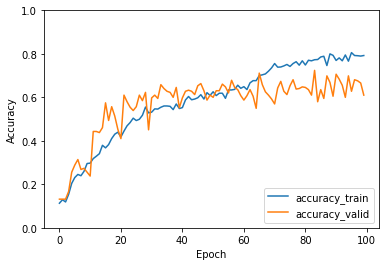

In [42]:
# GERANDO GRÁFICO COM RESULTADOS DAS ACURÁCIAS DE TREINO E VALIDAÇÃO #

plt.plot(history['accuracy'], label='accuracy_train')
plt.plot(history['val_accuracy'], label = 'accuracy_valid')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

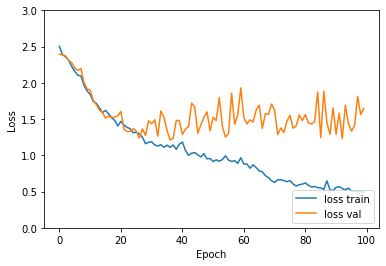

In [43]:
# GERANDO GRÁFICO COM RESULTADOS DO LOSS DE TREINO E VALIDAÇÃO #

plt.plot(history['loss'], label='loss train')
plt.plot(history['val_loss'], label='loss val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 3])
plt.legend(loc='lower right')

In [44]:
datagen_test =  ImageDataGenerator(rescale = 1./255) # comando para reescala das imagens de teste

# imagens de teste

test_data = datagen_test.flow_from_directory(directory='dataset_smkt/test',
                                                      target_size = (100, 100),
                                                      batch_size = 64,
                                                      shuffle=False)

Found 404 images belonging to 11 classes.


In [45]:
# DEFININDO COMANDO PARA AVALIAR O DESEMPENHO DO MODELO NAS IMAGENS DE TESTE #

test_loss, test_acc = model_n3.evaluate(test_data) # verificar versão do Keras

print("acurácia nos dados de teste:", test_acc)
print("loss dos dados de teste:", test_loss)

7/7 [==============================] - 4s 598ms/step - loss: 0.4939 - accuracy: 0.8515
acurácia nos dados de teste: 0.8514851331710815
loss dos dados de teste: 0.4939214587211609


In [46]:
Y_pred = model_n3.predict(test_data)
y_pred = np.argmax(Y_pred, axis=1)

print(y_pred.shape)

print('Accuracy')
print(accuracy_score(test_data.classes,y_pred))

print('Balanced Accuracy')
print(balanced_accuracy_score(test_data.classes,y_pred))

print('Confusion Matrix')
print(confusion_matrix(test_data.classes, y_pred))
print('Classification Report')

(404,)
Accuracy
0.8514851485148515
Balanced Accuracy
0.8032169317978604
Confusion Matrix
[[39  0  0  0  1  0  3  0  0  0  0]
 [ 0 25  1  0  0  0  0  0  0  0  5]
 [ 0  0 29  0  5  0  0  0  1  0  0]
 [ 0  0  0 22  0  0  0  0  0  0  0]
 [ 2  0  2  0 45  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  0  0  0 15  0]
 [ 5  0  0  0  0  0 38  0  0  0  0]
 [ 0  0  1  0  2  0  1 28  0  0  0]
 [ 0  0  1  0  0  0  0  0 52  0  0]
 [ 0  0  6  0  0  0  0  4  0 31  0]
 [ 0  3  1  0  0  0  0  0  0  0 35]]
Classification Report


#### Referência:

ROCHA, A. et al. Automatic fruit and vegetable classification from images. Computers and Electronics in Agriculture, v. 70, n. 1, p. 96-104, 2010.